# Моделирование рынка НКО в сфере здравоохранения
Некоммерческий сектор - один из важнейших работодателей в структуре экономики экономически развитых стран. Социальная значимость данного рынка крайне велика, однако до сих пор существует мало исследований этого сектора. И, несмотря на нехватку данных, отсутствуют попытки построить полноценную компьютерную модель для изучения данного сектора. В нашей работе мы сконцентрировались на моделировании рынка некоммерческих организаций в здравоохранении. Мы использовали метод агент-ориентированного моделирования.

## Описание модели

`Агент-ориентированная модель` - это компьютерная симуляция системы, состоящей из набора взаимодействующих агентов, каждый из которых независимо принимает решения, основываясь на наборе простых правил. Агенты получают информацию из внешней среды или от других агентов.

В нашей модели есть 3 вида агентов:
- Доноры (n = 100)
- НКО (n = 10)
- Пациенты (n = 100)

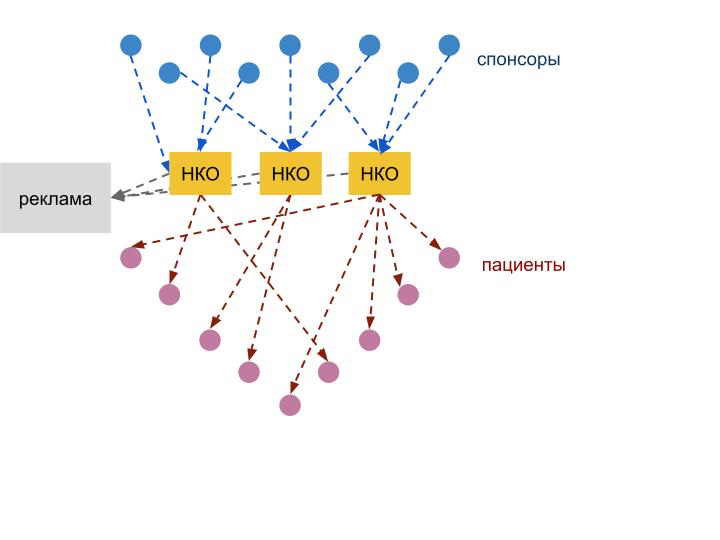


### Доноры (n = 100)

**Выбор организации.** Каждый i-тый спонсор получает сигнал от каждой  j-той организации. Сигнал зависит от общего бюджета организации. Доноры жертвуют организации, от которой получили самый сильный сигнал. Дисперсия сигнала зависит от того, сколько раз в предыдущих раундах i-тый спонсор жертвовал j-той НКО.

$$sig_{ij} \sim N(a = budget_j, \sigma^2= \frac{9}{1 + count(i, j)})$$

### НКО (n = 100)
**Траты на уставную деятельность и административные нужды.** По закону НКО обязано тратить не менее 80% бюджета на уставную деятельность, то есть на лечение пациентов.

$$med\_coef_j = unifom(0.8, 1)$$

$$med\_budget_j = med\_coef_j * budget_j$$

$$budget_j = med\_budget_j + adm\_budget_j$$


**Распределение бюджета между пациентами.** Организации пытаются максимизировать продолжительность жизни своих пациентов. Решаем задачу с помощью симплекс-метода.

$$
\left\{
    \begin{array}\\
        w_1^j * a_1 + w_2^j *a_2 + ... + w_k^j * a_k \rightarrow max \\
        w_i^j * a_i = \lambda_i \\
        a_i = e^{\beta_0^i}  \\
        w_i^j = e^{\beta_1 * budget_i^j} \\
        \sum_{i = 1}^{k}budget_i^j = budget_j
    \end{array}
\right.
$$


### Пациенты (n = 100)
**Выбор организации.** Получают сигнал от каждой организации. Сигнал приходит из нормального распределения и зависит от бюджета, выделенного на лечение. Пациенты идут в организацию, от которой получили самый сильный сигнал.

$$sig_{ij} \sim N(a = medbudget_j, \sigma^2=9)$$

**Выживание.** У каждого пациента есть изначальный параметр излечения $p_{survival}^i$. Вероятность вылечиться в этом раунде зависит от изначального прогноза и бюджета, потраченного на этого пациента.

$$p_{result}^{i} = \frac{1}{1 + \exp \{-(p_{survival}^i + budget_i) \}}$$

$$Bern(p_{result}^i)$$

**Продолжительность жизни.** В реальности в НКО, как правило, обращаются пациенты с неизлечимыми диагнозами. И НКО могут лишь вложиться в лечение, которое продлит ожидаемую продолжительность жизни пациентов. У пациента есть изначальный параметр, влияющий на ожидаемую продолжительность жизни $\beta_0^i$.

$$\lambda_i = \exp \{\beta_0^i + \beta_1 * budget_i\}$$

$$life\_expectancy = Pois(\lambda_i)$$



In [192]:
import numpy as np
from scipy.optimize import minimize

def objective_function(log_budgets, a):
    """Objective function to be maximized (in log space)."""
    # Конвертируем логарифмы обратно в веса
    budgets = np.exp(log_budgets)
    weights = budgets
    return -np.sum(weights * a)  # Минус для максимизации

def constraint_budget(log_budgets, total_budget):
    """Constraint: sum of budgets equals total budget constraint."""
    return np.sum(np.exp(log_budgets)) - total_budget

def optimize_weights(a, total_budget, initial_guess=None):
    """Finds optimal budgets using numerical optimization."""
    
    k = len(a)  # Количество переменных (a_i)
    
    # Начальное предположение (если не задано, используем логарифмы равномерного разделения)
    if initial_guess is None:
        initial_guess = np.zeros(k)  # Логарифм 1 = 0, начнем с нулей

    # Ограничения
    constraints = {'type': 'eq', 'fun': constraint_budget, 'args': (total_budget,)}
    
    # Блокировки для логарифмов бюджетов
    bounds = [(None, np.log(total_budget))] * k  # Логарифмические границы

    # Оптимизация
    result = minimize(objective_function, initial_guess, args=(a,), 
                      method='SLSQP', constraints=constraints, bounds=bounds)

    if result.success:
        return result.x, np.exp(result.x)  # Возвращаем и логарифмы, и исходные бюджеты
    else:
        print("Optimization failed:", result.message)
        return None, None

# Пример использования:
beta_0 = np.array([1.0, 2.0, 1.5, 0.5])  # a_i = e^(beta0_i)
total_budget = 10  # Общий бюджет

# Вычисляем a на основе beta_0
a = np.exp(beta_0)

optimal_log_budgets, optimal_budgets = optimize_weights(a, total_budget)

if optimal_log_budgets is not None:
    print("Оптимальные логарифмические бюджеты:", optimal_log_budgets)
    print("Оптимальные бюджеты:", optimal_budgets)
    max_value = -objective_function(optimal_log_budgets, a)
    print("Максимальное значение целевой функции:", max_value)

Оптимальные логарифмические бюджеты: [-14.81244729   2.30258507 -24.71593068 -17.33504584]
Оптимальные бюджеты: [3.69008081e-07 9.99999979e+00 1.84504809e-11 2.96131939e-08]
Максимальное значение целевой функции: 73.89056045715938


Optimization failed: Iteration limit reached


C:\Users\HOME\AppData\Local\Temp\ipykernel_16236\3185201667.py:3: RuntimeWarning: overflow encountered in exp
  weights = np.exp(budgets)  # w_i = e^(budget_i)


Optimization failed: Singular matrix C in LSQ subproblem


## Код

### Вопросы
- Выбывают ли у нас теперь организации?

## Закон об НКО

Реестр ЕГРЮЛ

https://www.nalog.gov.ru/opendata/7707329152-rsmp/

Отчёты организаций. На что тратили деньги?

http://unro.minjust.ru/NKOReports.aspx

In [35]:
import numpy as np
import math
from matplotlib import pyplot as plt
from statistics import mean
import pandas as pd
import scipy.stats as st
import seaborn as sns
from scipy.optimize import minimize
#from sympy import *



class SimpleAgentModel:

    class Donators:                        #  В модели 100 спонсоров.
        '''
         В каждом раунде спонсор отдаёт целиком 1 монетку j-той НКО, от которой он получил
         самый сильный сигнал self.signal[i][j]. Значение сигнала  self.signal[i][j] - это значение,
         сгенерированное из нормального распределения, дисперсия которого равна 9, а матожидание
         складывается из бюджета j-той организации на медицину и рекламу и коэффициентов
         предпочтения i-того спонсора.

         self.signal[i][j] ∼ N(a, 9)
         a = self.med_coef[i] * medbudjet[j] + self.adv_coef[i] * advbudjet[j]
        '''

        def __init__(self):
            self.signal = 0                #  Массив из сигналов от организаций
            self.prev_donations = 0        #  Сколько раз спонсор жертвовал организациям
                                           #  в предыдущих ранудахю
            self.reset()

        def reset(self):
            data_sig = { 0 : np.zeros(100), 1 : np.zeros(100), 2 : np.zeros(100), 3: np.zeros(100), 4 : np.zeros(100),
                         5 : np.zeros(100), 6 : np.zeros(100), 7 : np.zeros(100), 8 : np.zeros(100), 9 : np.zeros(100)}

            data_visited = {0 : np.zeros(100, int), 1 : np.zeros(100, int), 2 : np.zeros(100, int), 3 : np.zeros(100, int), 4 : np.zeros(100, int),
                         5 : np.zeros(100, int), 6 : np.zeros(100, int), 7 : np.zeros(100, int), 8 : np.zeros(100, int), 9 : np.zeros(100, int), 'choice' : np.zeros(100, int)}

            self.signal = pd.DataFrame.from_dict(data_sig)
            self.visited = pd.DataFrame.from_dict(data_visited)

            for column in self.signal.columns:
                self.signal[column] = np.random.normal(0, 9, 100)

    class Patients:                        #  В модели 100 пациентов.

        '''
         i-тый пациент в каждом раунде обращается за помощью в j-тую НКО, от которой он получил
         самый сильный сигнал self.signal[i][j]. При этом, если пациент уже обращался в
         j-тую организацию на прошлых раундах, то в этом раунде он туда не пойдёт.
        '''

        def __init__(self, graph_status = False):
            self.data = 0
            self.signal= 0
            self.count_cured = 0           #  Сколько всего вылечено пациентов?
            self.reset()

        def reset(self):
            # NetworkX - посмотреть
            #self.graph = np.random.binomial(n = 1, p = 0.25, size = (100, 100))
            data_dict = {'budget' : np.zeros(100), 'beta0' : np.random.uniform(0, 1, 100), 'lambda' : np.zeros(100), 'life_expectancy' : np.zeros(100), 'choice' : np.zeros(100, int)}

            data_sig = { 0 : np.zeros(100), 1 : np.zeros(100), 2 : np.zeros(100), 3 : np.zeros(100), 4 : np.zeros(100),
                         5 : np.zeros(100), 6 : np.zeros(100), 7 : np.zeros(100), 8 : np.zeros(100), 9 : np.zeros(100)}
            #data_visited = { '0' : np.zeros(100, bool), '1' : np.zeros(100, bool), '2' : np.zeros(100, bool), '3' : np.zeros(100, bool), '4' : np.zeros(100, bool),
                         #'5' : np.zeros(100, bool), '6' : np.zeros(100, bool), '7' : np.zeros(100, bool), '8' : np.zeros(100, bool), '9' : np.zeros(100, bool)}

            self.signal = pd.DataFrame.from_dict(data_sig)
            #self.visited = pd.DataFrame.from_dict(data_visited)
            self.data = pd.DataFrame.from_dict(data_dict)
            self.count_cured = 0

            for column in self.signal.columns:
                self.signal[column] = np.random.normal(0, 9, 100)


        def new_patient(self, i):
            pass



    class Organizations:

        '''
        Организация получает бюджет от спонсоров. Если бюджет нулевой, то НКО выбывает из игры.
        Если она получает ненулевой бюджет, то часть денег она тратит на медицину
        self.med_coef[j] * self.budget[j], а часть на рекламу self.adv_coef[j] * self.budget[j]
        '''

        def __init__(self, rational_status = False):
            self.data = 0
            self.patients_alive = 0
            self.rational_status = rational_status
            #print(rational_status)
            self.reset()

        def reset(self):
            data_dict = {'budget' : np.zeros(10), 'med_coef' : np.random.uniform(0.8, 1, 10), 'med_budget' : np.zeros(10),
                         'is_lost' : np.zeros(10, bool), 'laps' : np.zeros(10, int), 'all_patients' : np.zeros(10, int),
                         'life_expectancy' : np.zeros(10), 'count_patients' : np.zeros(10, int)}
            patients_alive = {1 : np.zeros(10, int), 2 : np.zeros(10, int), 3 : np.zeros(10, int), 4 : np.zeros(10, int), 5 : np.zeros(10, int), 
                              6 : np.zeros(10, int), 7 : np.zeros(10, int), 8 : np.zeros(10, int), 9 : np.zeros(10, int), 10 : np.zeros(10, int),
                              11 : np.zeros(10, int), 12 : np.zeros(10, int), 13 : np.zeros(10, int), 14 : np.zeros(10, int), 15 : np.zeros(10, int)
                             }
            
            self.data = pd.DataFrame.from_dict(data_dict)
            self.alive_patients = pd.DataFrame(patients_alive)

    '''
    Конец описания подклассов.
    '''

    def __init__(self, graph_status = False, diag_count = 1, rational_status = False):
        self.donators = SimpleAgentModel.Donators()
        self.patients = SimpleAgentModel.Patients()
        self.organizations = SimpleAgentModel.Organizations(rational_status)

    def count_alive_patients(self, org_i):
        return self.organizations.alive_patients.loc[org_i].sum()

    def update_alive_patients(self):
        for i in range(1, 15):
            self.organizations.alive_patients[i] = self.organizations.alive_patients[i + 1]
        self.organizations.alive_patients[15] = np.zeros(10)


    def objective_function(self, budgets, a):
        """Objective function to be maximized (in log space)."""
        #return (budgets + a)
        #return -(np.median((np.exp(budgets) + np.exp( a))) )
        return -(np.median((budgets +  a)))
        #return min(budgets * a)  # Минус для максимизации

    def constraint_budget(self, budgets, total_budget):
        """Constraint: sum of budgets equals total budget constraint."""
        return np.sum((budgets)) - total_budget

    def donation(self):
        self.organizations.data['budget'] = 0
        self.organizations.data['med_budget'] = 0
        self.donators.visited['choice'] = self.donators.signal.idxmax(axis ='columns').astype(int)
        #print(self.organizations.data['budget'])

        for i in range(10):                
            self.donators.visited.loc[self.donators.visited['choice'] == i, i] += 1
            self.organizations.data.loc[i, 'budget'] = self.donators.visited[self.donators.visited['choice'] == i].shape[0]
            
        #self.organizations.data.loc[self.organizations.data['budget'] == 0, 'is_lost'] = 1
            
        #print(self.organizations.data['budget'])

    def budget_med_or_adv(self):
        self.organizations.data.loc[self.organizations.data['budget'] == 0, 'is_lost'] = True
        self.organizations.data.loc[self.organizations.data['is_lost'] == False, 'laps'] += 1
        self.organizations.data.loc[self.organizations.data['is_lost'] == False, 'med_budget'] = self.organizations.data['budget'] * self.organizations.data['med_coef']


    def choose_organization(self):
        for i in range(10):
            if self.organizations.data.loc[i, 'is_lost'] == False:
                a = self.organizations.data.loc[i, 'med_budget'] / (self.organizations.data.loc[i, 'count_patients'] + 1) + self.organizations.data.loc[i, 'life_expectancy']
                #a = self.organizations.data.loc[i, 'med_budget'] + self.organizations.data.loc[i, 'life_expectancy']
                self.patients.signal[i] = np.random.normal(a, 9, 100)
            else:
                self.patients.signal[i] = -100

        #for i in range(10):
            #self.patients.signal.loc[self.patients.visited[str(i)], str(i)] = -100

        self.patients.data['choice'] = self.patients.signal.idxmax(axis ='columns').astype(int)

        #for i in range(10):
        #    self.patients.visited.loc[self.patients.data['choice'] == i, str(i)] = True

        for i in range(10):
            self.organizations.data.loc[i, 'count_patients'] = self.patients.data[self.patients.data['choice'] == i].shape[0]
            self.organizations.data.loc[i, 'all_patients'] += self.organizations.data.loc[i, 'count_patients']


    def budget_between_patient(self): #  Может ли организация не принять?
        self.organizations.data.loc[self.organizations.data['count_patients'] == 0, 'is_lost'] = True
        #print('Бюджеты организаций:', self.organizations.data['med_budget'].values)
        #print('Количество пациентов:', self.organizations.data['count_patients'].values)

        for i in range(10):
            
            if self.organizations.data.loc[i, 'is_lost'] == True:
                continue
                
            patients_count = self.organizations.data.loc[i, 'count_patients']
            total_budget = self.organizations.data.loc[i, 'med_budget']
            
            if patients_count <= 1:
                budget_i = self.organizations.data.loc[i, 'med_budget']
                self.patients.data.loc[self.patients.data['choice'] == i, 'budget'] = budget_i
                continue
                
            if self.organizations.rational_status:
                #print('Распределяем рационально бюджет в организации', i + 1)
                
                a = self.patients.data.loc[self.patients.data['choice'] == i, 'beta0']
                initial_guess = np.ones(patients_count)
                constraints = {'type': 'eq', 'fun': self.constraint_budget, 'args': (total_budget,)}
                bounds = [(0, total_budget)] * patients_count  # Логарифмические границы
                result = minimize(self.objective_function, initial_guess, args=(a,), method='SLSQP', constraints=constraints, bounds=bounds)
               
                if result.success:
                    #optimal_log_budgets, optimal_budgets = result.x, np.exp(result.x)  # Возвращаем и логарифмы, и исходные бюджеты
                    #print(total_budget, result.x)
                    self.patients.data.loc[self.patients.data['choice'] == i, 'budget'] =  result.x
                    continue
                    
            self.patients.data.loc[self.patients.data['choice'] == i, 'budget'] = total_budget / patients_count
            


    def survival(self):
        self.patients.data['lambda'] = self.patients.data['budget'] + self.patients.data['beta0']
        self.patients.data['lambda'] = self.patients.data['lambda'].apply(lambda x: np.exp(x))
        self.patients.data['life_expectancy'] = self.patients.data['lambda'].apply(lambda x: np.random.poisson(x))

        for i in range(10):
            self.organizations.data.loc[i, 'life_expectancy'] = self.patients.data.loc[self.patients.data['choice'] == i, 'life_expectancy'].mean()
            for j in range(1, 16):
                self.organizations.alive_patients.loc[i, j] = self.patients.data.loc[(self.patients.data['choice'] == i) & (self.patients.data['life_expectancy'] == j)].shape[0]

    def set_new_preferences(self):
        for i in range(10):
            if self.organizations.data.loc[i, 'is_lost']:
                self.donators.signal[i] = -100
            else:
                a = np.log1p(self.count_alive_patients(i) + (self.organizations.data.loc[i, 'budget'] - (self.organizations.data.loc[i, 'med_budget'] ))
                #a = (self.count_alive_patients(i) + self.organizations.data.loc[i, 'budget'])
                self.donators.signal[i] = self.donators.visited[i].apply(lambda x: np.random.normal(a, 9 / (1 + (x + 1))))
                #self.donators.signal[i] = self.donators.visited[i].apply(lambda x: np.random.normal(a, 9 / (1 + np.log2(x + 2))))
    
        
        #self.organizations.data['budget'] = 0
        self.update_alive_patients()
        
        #self.patients.reset()



    def lap(self):
        self.donation()
        self.budget_med_or_adv()
        self.choose_organization()
        self.budget_between_patient()
        self.survival()
        self.set_new_preferences()
        return self

    def count_organizations(self):
        return self.organizations.data[self.organizations.data['is_lost'] == False].shape[0]

    def simulation(self, laps_count = 10, verbose = False):
        self.donators.reset()
        self.patients.reset()
        self.organizations.reset()

        for i in range(laps_count):
            self.lap()
            if self.count_organizations() <= 1:
                return self
            self.patients.reset()
        return self




In [ ]:
model = SimpleAgentModel(rational_status = True)
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'med_budget' : [], 'laps' : [], 'is_lost' : []})

alive = pd.DataFrame({0 : []})

for i in range(100):
    res = model.simulation()
    
    alive_df = pd.DataFrame({0 : [model.count_alive_patients(j) for j in range(10)]})
    
    model.organizations.patients_alive
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'med_budget', 'budget', 'laps', 'is_lost']]])
    alive = pd.concat([alive, alive_df])

df['alive'] = alive[0]
df.head(10)

In [50]:
model = SimpleAgentModel(rational_status = True)
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'med_budget' : [], 'laps' : [], 'is_lost' : []})

alive = pd.DataFrame({0 : []})

for i in range(100):
    res = model.simulation()
    
    alive_df = pd.DataFrame({0 : [model.count_alive_patients(j) for j in range(10)]})
    
    model.organizations.patients_alive
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'med_budget', 'budget', 'laps', 'is_lost']]])
    alive = pd.concat([alive, alive_df])

df['alive'] = alive[0]
df.head(10)

ValueError: lam value too large

<Axes: xlabel='laps', ylabel='Count'>

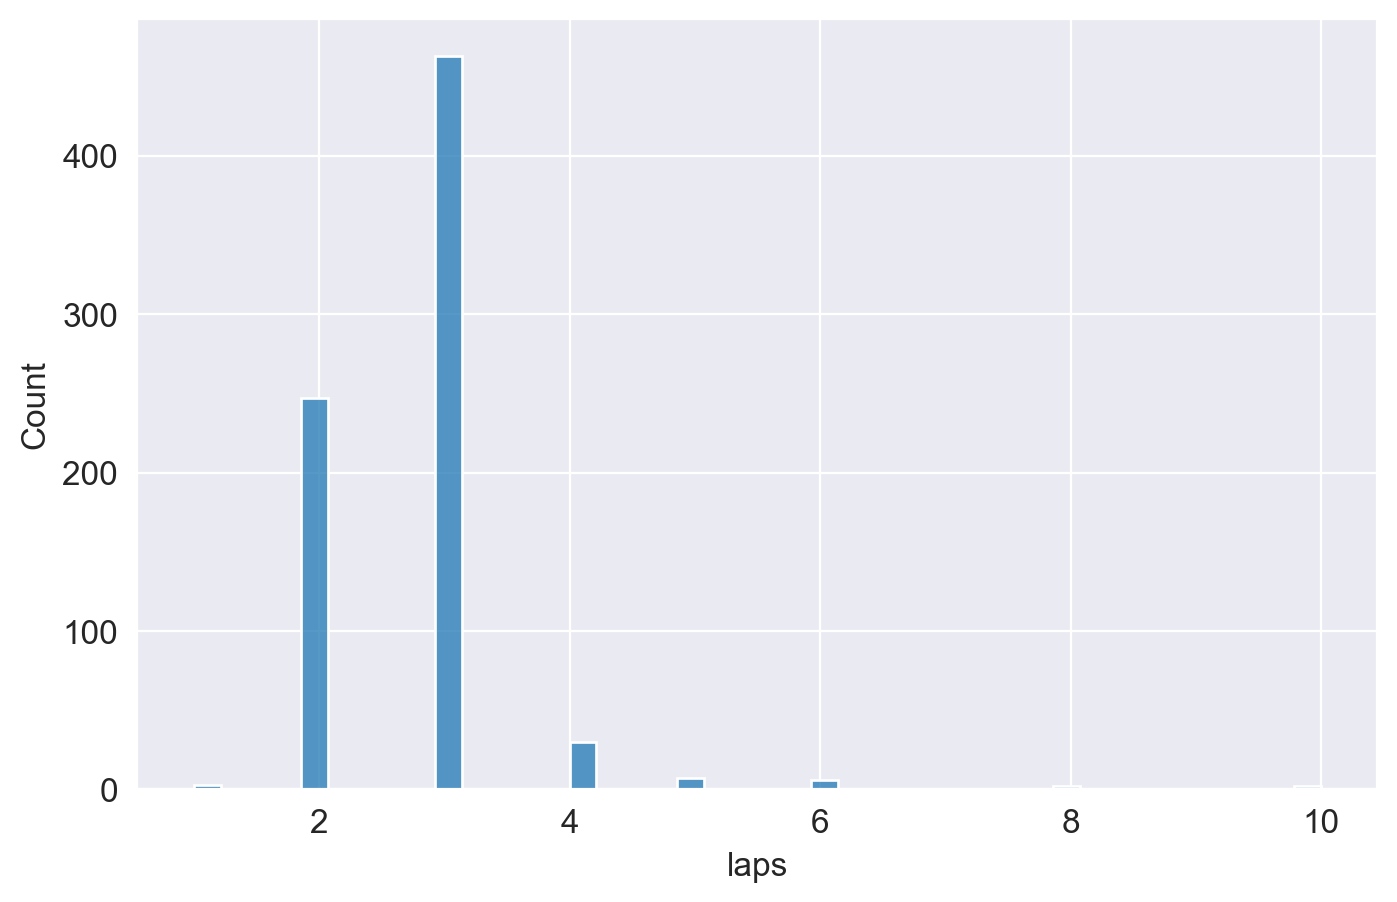

In [54]:
#model.patients.data['lambda'].sort_values()
df

sns.histplot(data = df, x = 'laps')

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_oldcore.py:1134: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


ValueError: cannot reindex on an axis with duplicate labels

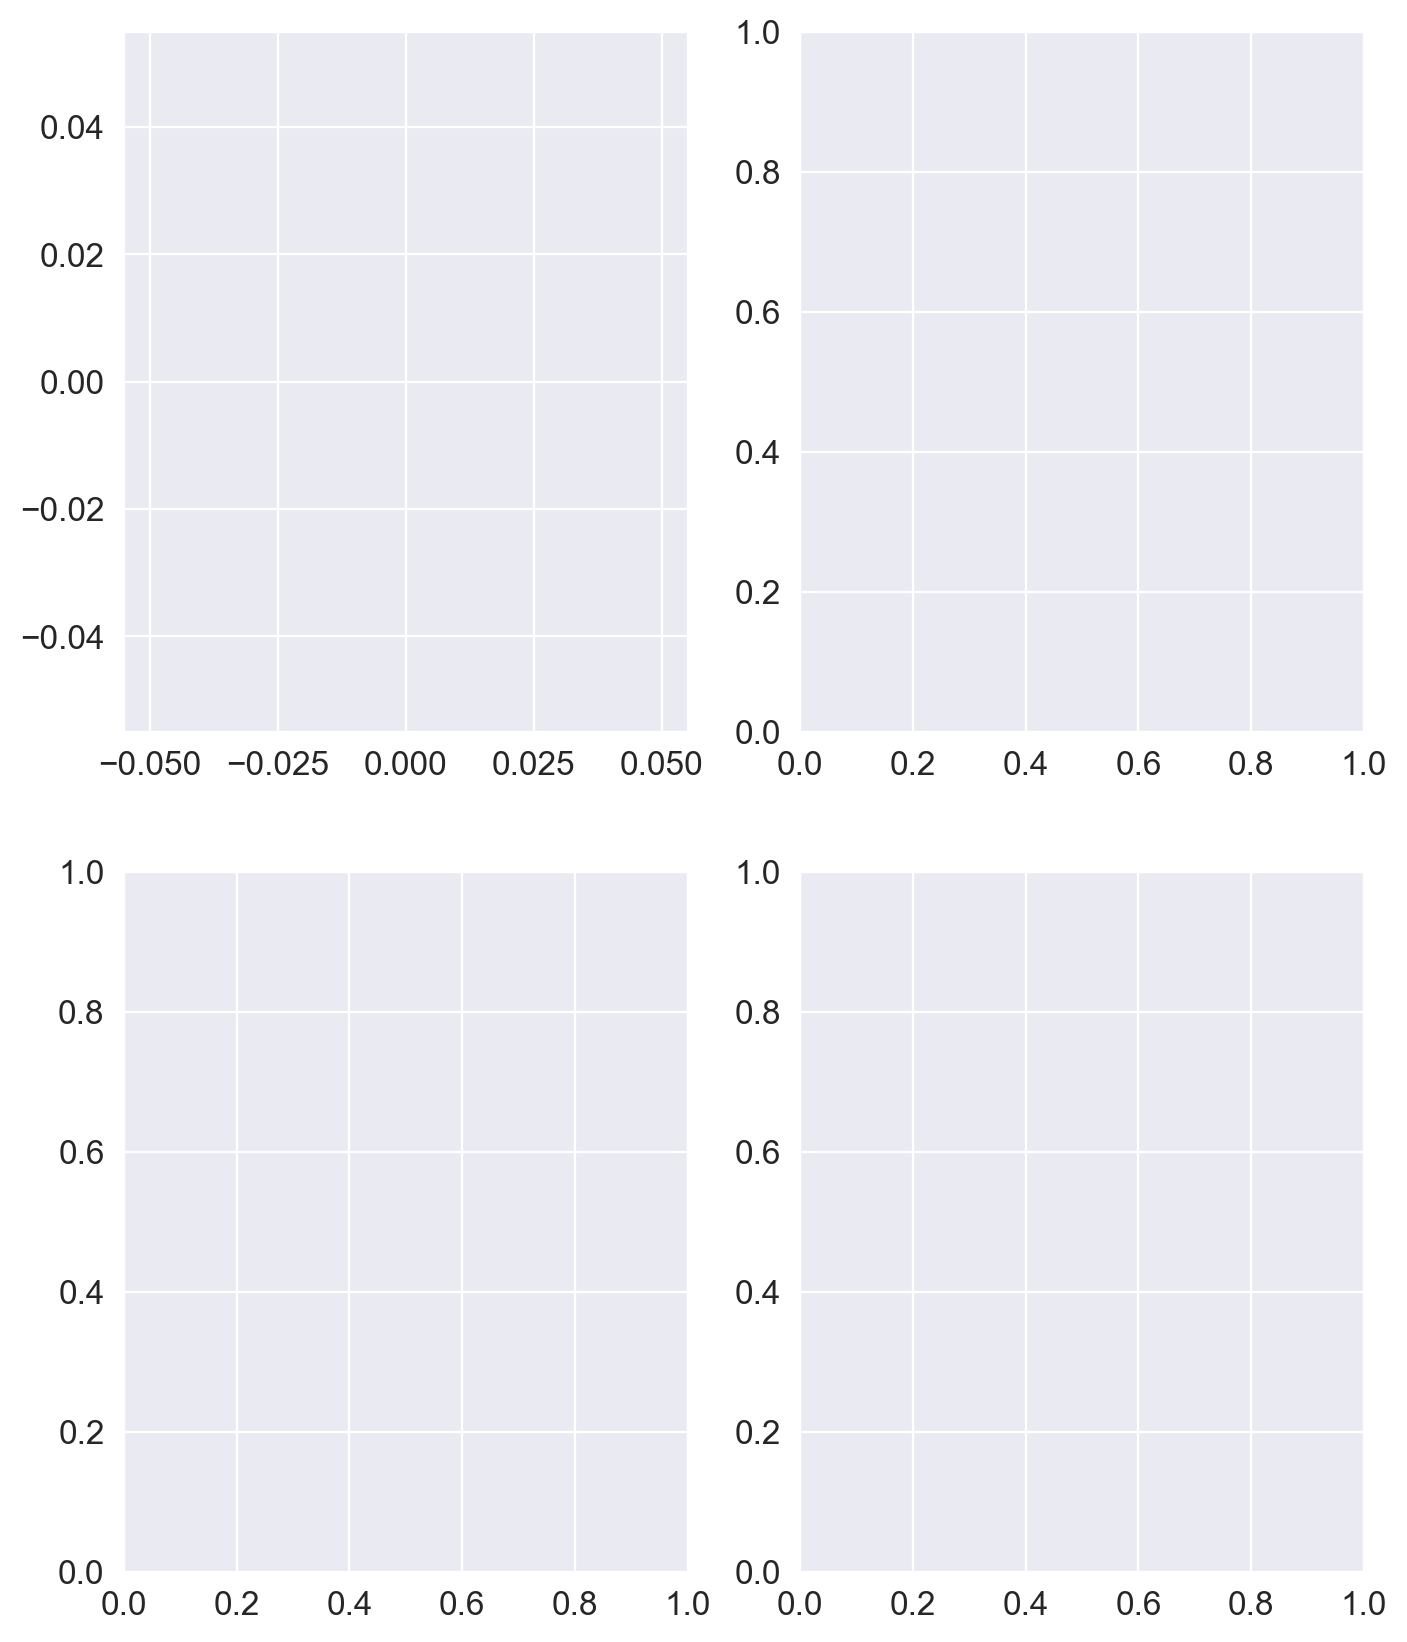

In [52]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

figure, axes = plt.subplots(2, 2, figsize=(8, 10))

sns.histplot(ax = axes[0, 0], data = df, x = 'life_expectancy')
sns.histplot(ax = axes[0, 1], data = df, x = 'laps')
sns.regplot(ax = axes[1, 0], data = df, x = 'med_coef', y = 'life_expectancy' )



In [36]:
model = SimpleAgentModel(rational_status = True)
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'med_budget' : [], 'laps' : [], 'is_lost' : []})

alive = pd.DataFrame({0 : []})

for i in range(5):
    res = model.lap()
    
    alive_df = pd.DataFrame({0 : [model.count_alive_patients(j) for j in range(10)]})
    
    model.organizations.patients_alive
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'med_budget', 'budget', 'laps', 'is_lost']]])
    alive = pd.concat([alive, alive_df])


In [37]:
'''
При таких условиях:

Сигналы для доноров
a = (self.count_alive_patients(i) + self.organizations.data.loc[i, 'budget'])
self.donators.signal[i] = self.donators.visited[i].apply(lambda x: np.random.normal(a, 9 / (1 + (x + 1))))

'''


df['alive'] = alive[0]
df.tail(10)

,med_coef,life_expectancy,count_patients,budget,med_budget,laps,is_lost,alive
0,0.989310,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
1,0.923533,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
2,0.997016,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
3,0.876057,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
4,0.941100,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
5,0.987472,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
6,0.866834,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
7,0.919570,NaN,0.0,0.0,0.00000,3.0,1.0,0.0
8,0.910043,4.16,100.0,100.0,91.00435,5.0,0.0,88.0
9,0.965814,NaN,0.0,0.0,0.00000,3.0,1.0,0.0


1. Когда ввела в функцию сигнала от организации к пациенту ожидаемую продолжительность жизни, корреляция медицинского коэффициента и продолжительности жизни стала отрицательной. Удивительно...
2. Когда ввела в функцию сигнала от организации к донору количество живых пациентов, корреляция медицинского коэффициента и продолжительности жизни стала слааабо положительной...

Пациенты ничего не решают? Всё решают доноры...

In [2]:
model = SimpleAgentModel()
#model.patients.data.dtypes
result = model.simulation()



False
Бюджеты организаций: [15.22423066  4.01682369  5.29345522  9.290319    8.30396929  9.97539309
  8.86380491  8.72862415  7.32311149 13.94839704]
Количество пациентов: [21  5  1 10  7  9 12 10  4 21]
Бюджеты организаций: [10.46665858  2.41009421  3.52897014  8.3612871   8.30396929 13.60280876
  6.44640357 13.57785979 11.90005617 12.95208297]
Количество пациентов: [  0   0 100   0   0   0   0   0   0   0]
Бюджеты организаций: [ 8.56362975  2.41009421 27.34951862  5.5741914   5.8127785   7.25483134
  4.83480268  6.78892989  5.49233362 16.93733926]
Количество пациентов: [  0   0 100   0   0   0   0   0   0   0]
Бюджеты организаций: [11.418173    7.23028264 14.11588058  8.3612871   4.98238158 10.88224701
  8.86380491  4.84923564  5.49233362 13.94839704]
Количество пациентов: [  0   0 100   0   0   0   0   0   0   0]
Бюджеты организаций: [ 8.56362975 10.4437416  12.3513955   6.5032233   4.98238158 10.88224701
  4.02900223 10.6683184   6.40772255 15.94102519]
Количество пациентов: [  0  

In [4]:
model.donators.signal

,0,1,2,3,4,5,6,7,8,9
0,-2.433893,-1.855081,3.244152,7.677326,-1.166065,8.540370,7.466082,3.831761,-1.606288,2.453334
1,1.574044,2.553188,0.805229,6.756778,7.152775,2.775836,-0.199416,2.410759,0.819045,0.479540
2,-2.208037,2.971381,6.724401,3.011781,5.670610,1.150241,-0.789489,1.069940,-0.126633,9.716734
3,7.381224,5.578243,3.260435,7.414233,8.300095,-1.781437,1.792577,5.784565,-2.856996,-1.055494
4,1.431115,1.796487,6.407955,1.755716,1.169334,-0.457783,2.016661,6.965155,2.277576,3.928645
...,...,...,...,...,...,...,...,...,...,...
95,1.024512,-2.382867,18.588391,1.670355,1.893576,3.290431,6.537330,5.683492,-1.914564,5.932211
96,3.595319,4.590957,6.742234,-1.211980,2.000872,0.561290,-9.870435,7.022933,2.438940,-0.135510
97,-3.109646,2.781751,7.816219,3.051196,2.544691,4.989716,-2.163460,7.497123,0.768826,-0.559687
98,4.795184,4.661030,2.827274,5.988207,2.099651,-1.041532,-2.904336,3.172147,1.872357,-3.401579


In [17]:
model = SimpleAgentModel(rational_status = True)
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'med_budget' : [], 'laps' : [], 'is_lost' : []})

#alive = pd.DataFrame({i : [] for i in range(15)})
alive = pd.DataFrame({0 : []})

for i in range(5):
    res = model.lap()
    
    alive_df = pd.DataFrame({0 : [model.count_alive_patients(j) for j in range(10)]})
    
    model.organizations.patients_alive
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'med_budget', 'budget', 'laps', 'is_lost']]])
    alive = pd.concat([alive, alive_df])

True
Бюджеты организаций: [ 7.38881719  6.96282249 10.43964182  9.53108282 13.86211734  8.88037204
  9.23486687 11.4498279   5.49799847  7.02905829]
Количество пациентов: [ 7  8 14  9 28  8 14  5  3  4]
Бюджеты организаций: [ 9.23602148 10.44423374  9.56967167 10.48419111  8.3172704   8.88037204
 15.95113369  6.67906627  7.33066462  2.63589686]
Количество пациентов: [  0   0   0   0   0   0   0 100   0   0]
Бюджеты организаций: [11.08322578  6.09246968 11.30961197  7.62486626  4.62070578  9.76840925
  8.39533352 20.99135115  7.33066462  3.51452915]
Количество пациентов: [  0   0   0   0   0   0   0 100   0   0]
Бюджеты организаций: [ 4.61801074  6.09246968  5.21982091 10.48419111  8.3172704  14.20859527
  2.51860006 22.8996558  11.91233001  5.27179372]
Количество пациентов: [  0   0   0   0   0   0   0 100   0   0]
Бюджеты организаций: [ 6.46521504  8.70352812  4.34985076  7.62486626  8.3172704  15.98466968
  5.03720011 19.0830465   7.33066462  7.90769058]
Количество пациентов: [  0   

In [18]:
'''
При таких условиях:

Сигналы для доноров
a = np.log1p(self.count_alive_patients(i) + self.organizations.data.loc[i, 'budget'])
self.donators.signal[i] = self.donators.visited[i].apply(lambda x: np.random.normal(a, 9 / (1 + (x + 1))))

'''


df['alive'] = alive[0]
df.head(30)

,med_coef,life_expectancy,count_patients,budget,med_budget,laps,is_lost,alive
0,0.923602,8.000000,7.0,8.0,7.388817,1.0,0.0,6.0
1,0.870353,4.625000,8.0,8.0,6.962822,1.0,0.0,7.0
2,0.869970,6.000000,14.0,12.0,10.439642,1.0,0.0,10.0
3,0.953108,9.000000,9.0,10.0,9.531083,1.0,0.0,5.0
4,0.924141,3.178571,28.0,15.0,13.862117,1.0,0.0,21.0
5,0.888037,6.750000,8.0,10.0,8.880372,1.0,0.0,7.0
6,0.839533,4.071429,14.0,11.0,9.234867,1.0,0.0,10.0
7,0.954152,58.400000,5.0,12.0,11.449828,1.0,0.0,1.0
8,0.916333,24.000000,3.0,6.0,5.497998,1.0,0.0,0.0
9,0.878632,15.500000,4.0,8.0,7.029058,1.0,0.0,1.0


In [5]:
model = SimpleAgentModel(rational_status = True)
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'med_budget' : [], 'laps' : [], 'is_lost' : []})

#alive = pd.DataFrame({i : [] for i in range(15)})
alive = pd.DataFrame({0 : []})

for i in range(5):
    res = model.lap()
    
    alive_df = pd.DataFrame({0 : [model.count_alive_patients(j) for j in range(10)]})
    
    model.organizations.patients_alive
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'med_budget', 'budget', 'laps', 'is_lost']]])
    alive = pd.concat([alive, alive_df])
    

True
Бюджеты организаций: [12.18524792  9.69189473  5.75440687 11.60684025  8.45507942 12.55324597
  5.72545574 11.81102345  5.1025704   9.76295043]
Количество пациентов: [15 14  4  9 11 23  5  8  1 10]
Бюджеты организаций: [ 6.56128734  8.72270526  9.04263937  6.77065681  8.45507942 15.45014889
  8.17922248  6.88976368 13.6068544   7.10032759]
Количество пациентов: [  0   0   0   0   0   0   0   0 100   0]
Бюджеты организаций: [ 7.49861411  8.72270526 11.50881374  3.86894675  8.45507942 10.62197736
  8.99714473  4.92125977 17.85899639  7.10032759]
Количество пациентов: [  0   0   0   0   0   0   0   0 100   0]
Бюджеты организаций: [ 8.43594087 10.6610842   3.2882325  10.63960356 13.15234576 10.62197736
  5.72545574  7.87401564 17.00856799  4.43770474]
Количество пациентов: [  0   0   0   0   0   0   0   0 100   0]
Бюджеты организаций: [ 7.49861411  6.78432631  3.2882325   8.70513019  9.39453269  6.75944014
  6.54337799 13.77952736 22.96156679  5.32524569]
Количество пациентов: [  0   

In [6]:
df['alive'] = alive[0]

In [7]:
df.head(30)

,med_coef,life_expectancy,count_patients,budget,med_budget,laps,is_lost,alive
0,0.937327,4.400000,15.0,0.0,12.185248,1.0,0.0,9.0
1,0.969189,4.571429,14.0,0.0,9.691895,1.0,0.0,12.0
2,0.822058,9.250000,4.0,0.0,5.754407,1.0,0.0,3.0
3,0.967237,10.777778,9.0,0.0,11.606840,1.0,0.0,2.0
4,0.939453,4.636364,11.0,0.0,8.455079,1.0,0.0,7.0
5,0.965634,3.000000,23.0,0.0,12.553246,1.0,0.0,16.0
6,0.817922,12.200000,5.0,0.0,5.725456,1.0,0.0,2.0
7,0.984252,17.375000,8.0,0.0,11.811023,1.0,0.0,1.0
8,0.850428,234.000000,1.0,0.0,5.102570,1.0,0.0,0.0
9,0.887541,6.600000,10.0,0.0,9.762950,1.0,0.0,8.0


In [296]:
#model.organizations.data[['med_coef', 'budget']].loc[0]
#model.donators.signal
model.organizations.data

,budget,med_coef,med_budget,is_lost,laps,all_patients,life_expectancy,count_patients
0,11,0.840889,9.249777,False,5,45,1.937500,16
1,11,0.998370,10.982069,False,5,79,1.545455,11
2,11,0.915732,10.073047,False,5,47,2.833333,6
3,4,0.894758,3.579034,False,5,29,2.000000,2
4,17,0.915936,15.570906,False,5,62,1.882353,17
5,5,0.906917,4.534584,False,5,30,2.000000,3
6,10,0.926836,9.268358,False,5,34,2.333333,6
7,7,0.841029,5.887204,False,5,13,3.000000,1
8,9,0.927055,8.343497,False,5,40,2.636364,11
9,15,0.935121,14.026809,False,5,121,1.925926,27


In [234]:
model.patients.data

,budget,beta0,lambda,life_expectancy,choice
0,0.0,0.631229,1.879920,1,1
1,1.0,0.112388,3.041614,3,1
2,0.0,0.149076,1.160761,1,1
3,1.0,0.646056,5.186486,5,1
4,0.0,0.349595,1.418493,1,1
...,...,...,...,...,...
95,0.0,0.816732,2.263092,2,1
96,0.0,0.283247,1.327433,1,1
97,0.0,0.996428,2.708590,3,1
98,0.0,0.733661,2.082691,1,1


<Axes: xlabel='life_expectancy', ylabel='Count'>

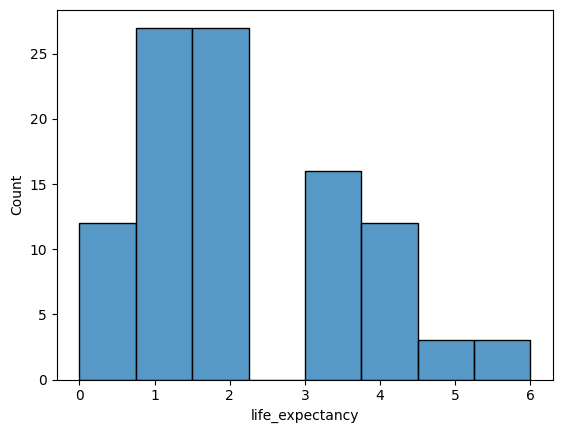

In [116]:
model.patients.data['life_expectancy']

sns.histplot(x = model.patients.data['life_expectancy'])

In [180]:
df = pd.DataFrame({ 'med_coef' : [], 'life_expectancy' : [], 'count_patients' : [], 'budget' : [], 'laps' : []})

for i in range(100):
    model = SimpleAgentModel()
    result = model.simulation()
    df = pd.concat([df, model.organizations.data[['med_coef', 'life_expectancy', 'count_patients', 'budget', 'laps']]])
    


<Axes: xlabel='laps', ylabel='Count'>

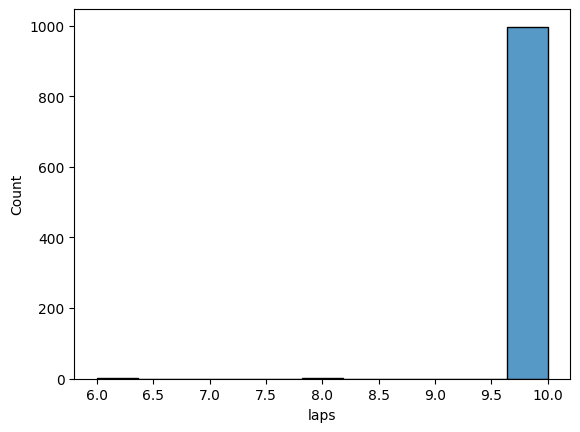

In [163]:
sns.histplot(data = df, x = 'laps')

<Axes: xlabel='med_coef', ylabel='life_expectancy'>

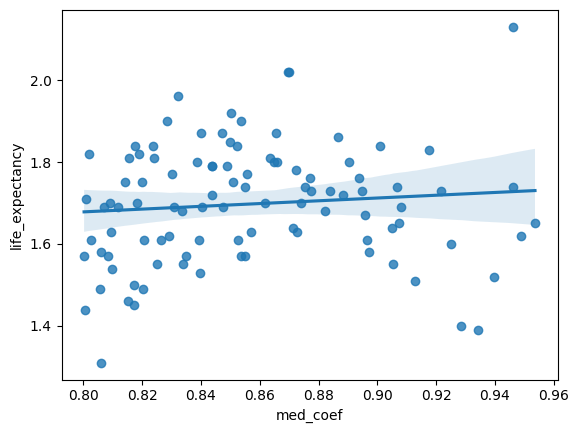

In [181]:
sns.regplot(data = df, x = 'med_coef', y = 'life_expectancy' )

<Axes: xlabel='med_coef', ylabel='count_patients'>

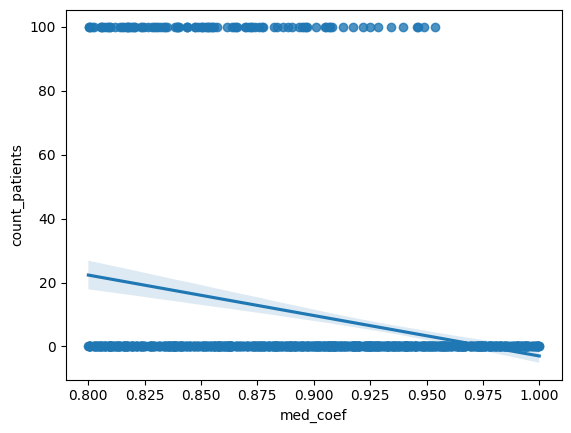

In [183]:


sns.regplot(data = df, x = 'med_coef', y = 'count_patients' )

<Axes: xlabel='med_coef', ylabel='all_patients'>

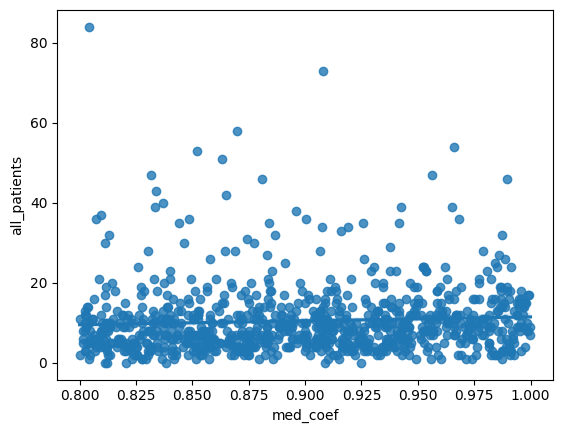

In [103]:

sns.regplot(data = df[df['all_patients'] < 100], x = 'med_coef', y = 'all_patients' )

<Axes: xlabel='med_coef', ylabel='all_patients'>

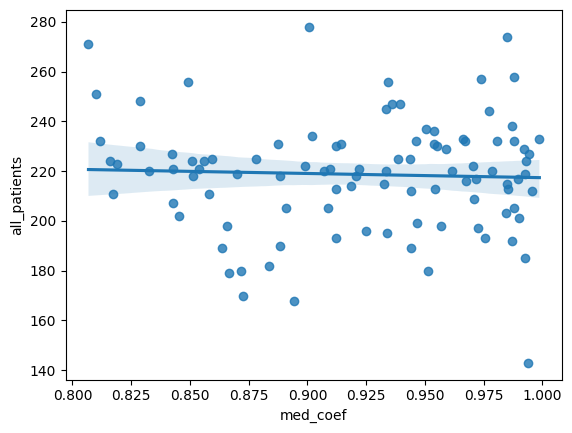

In [104]:

sns.regplot(data = df[df['all_patients'] > 100], x = 'med_coef', y = 'all_patients' )

<Axes: xlabel='med_coef', ylabel='laps'>

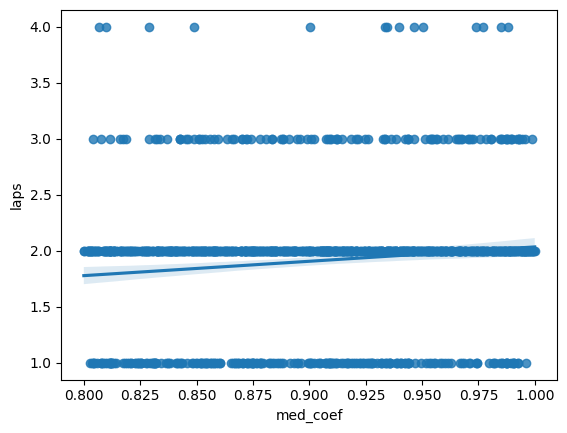

In [105]:
sns.regplot(data = df, x = 'med_coef', y = 'laps' )

In [106]:
df

,med_coef,life_expectancy,all_patients,budget,laps
0,0.972504,NaN,9.0,0.0,2.0
1,0.923827,NaN,5.0,0.0,2.0
2,0.913606,NaN,18.0,0.0,2.0
3,0.997748,NaN,15.0,0.0,2.0
4,0.876316,NaN,4.0,0.0,2.0
...,...,...,...,...,...
5,0.865511,NaN,5.0,0.0,2.0
6,0.933690,1.64,195.0,100.0,3.0
7,0.859572,NaN,3.0,0.0,1.0
8,0.930392,NaN,24.0,0.0,2.0
